<a href="https://colab.research.google.com/github/jockylover/LSTM/blob/main/Dataset_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset preparation

In this notebook, we will build and pre-process the arXiv paper dataset.

In [4]:
# imports
import sys
sys.path.insert(0, "../")
from dataset import ArXivDataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import nltk

# Download the stopwords resource
nltk.download('stopwords')

# Now you can use the stopwords
from nltk.corpus import stopwords

# Example usage
stop_words = set(stopwords.words('english'))
print("Stopwords downloaded and loaded successfully.")


Stopwords downloaded and loaded successfully.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


I used a variety of techniques to pre-process the text, such as the removal of LaTex equations, tokenization, n-gram phrase detection, and lemmatization.

In [7]:
# build and pre-process texts
metadata_filepath = "/content/drive/MyDrive/arxiv-metadata-oai-snapshot.json"
dataset = ArXivDataset.from_metadata(metadata_filepath)
print("# papers: {n}".format(n=len(dataset)))

 [1/6] Removing LaTex equations...
 [2/6] Removing newlines and extra spaces...
 [3/6] Tokenizing documents...
 [4/6] Removing stopwords...
 [5/6] Identifying n-gram phrases...
 [6/6] Lemmatizing...
 Done.
# papers: 390151


Now that the texts have been pre-processed, they can be exported as a dataset object.

In [ ]:
# export dataset
dataset.save("./data/dataset.obj")

In [ ]:
!pip install bertopic sentence-transformers umap-learn hdbscan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 94.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 M

In [ ]:
import sys
sys.path.insert(0, "../")
import os
import numpy as np
import pandas as pd
from dataset import ArXivDataset
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import logging

sns.set_context("talk")
sns.set_style("ticks")

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def main():
    try:
        # Load dataset
        dataset_path = "./data/dataset.obj"
        dataset = ArXivDataset.load(dataset_path)
        logging.info(f"# papers: {len(dataset)}")

        # Ensure all documents are strings
        documents = [str(doc) for doc in dataset.documents]

        # Load sentence transformer model with controlled parallelism
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

        # Embed documents
        logging.info("Embedding documents...")
        embeddings = sentence_model.encode(documents, show_progress_bar=True, batch_size=32)

        # Create BERTopic model
        topic_model = BERTopic(nr_topics="auto", calculate_probabilities=True)

        # Fit the model
        logging.info("Fitting BERTopic model...")
        topics, probs = topic_model.fit_transform(documents, embeddings)

        # Get topic coherence
        logging.info("Calculating coherence score...")
        coherence_score = topic_model.get_coherence("c_v")
        logging.info(f"Coherence score: {coherence_score:.3f}")

        # Plot topic sizes
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.set_title("Topic sizes")
        topic_sizes = topic_model.get_topic_sizes()
        sns.barplot(x=topic_sizes.index, y=topic_sizes.values, color="#DB5461", ax=ax)
        ax.set_xlabel("Topic")
        ax.set_ylabel("Size")
        plt.show()

        # Save the model
        model_path = "./models/bertopic_model"
        topic_model.save(model_path)
        logging.info(f"Model saved to {model_path}")

    except Exception as e:
        logging.error(f"An error occurred: {e}", exc_info=True)

if __name__ == '__main__':
    main()


Batches:   0%|          | 0/12193 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
import sys
sys.path.insert(0, "../")
import os
import numpy as np
import pandas as pd
from dataset import ArXivDataset
from gensim.models import LdaModel, LsiModel, HdpModel, CoherenceModel
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")

def main():
    # Load dataset
    dataset_path = "./data/dataset.obj"
    dataset = ArXivDataset.load(dataset_path)
    print("# papers: {s}".format(s=len(dataset)))

    # Set hyperparameters
    num_topics_list = [10, 11, 12, 13, 14, 15, 16]
    num_passes = 5
    random_state = 929

    # Run grid search for LDA
    lda_model_list = []
    lda_score_list = []
    for num_topics in num_topics_list:
        model = LdaModel(
            corpus=dataset.corpus,
            id2word=dataset.idx2word,
            num_topics=num_topics,
            passes=num_passes,
            random_state=random_state,
            per_word_topics=True
        )
        lda_model_list.append(model)
        coherence_model = CoherenceModel(
            model=model,
            texts=dataset.documents,
            dictionary=dataset.idx2word,
            coherence="c_v"
        )
        score = coherence_model.get_coherence()
        lda_score_list.append(score)
        print("LDA * num_topics: {n:02d}\tscore: {s:.3f}".format(n=num_topics, s=score))

    # Run grid search for LSI
    lsi_model_list = []
    lsi_score_list = []
    for num_topics in num_topics_list:
        model = LsiModel(
            corpus=dataset.corpus,
            id2word=dataset.idx2word,
            num_topics=num_topics
        )
        lsi_model_list.append(model)
        coherence_model = CoherenceModel(
            model=model,
            texts=dataset.documents,
            dictionary=dataset.idx2word,
            coherence="c_v"
        )
        score = coherence_model.get_coherence()
        lsi_score_list.append(score)
        print("LSI * num_topics: {n:02d}\tscore: {s:.3f}".format(n=num_topics, s=score))

    # Run grid search for HDP
    hdp_model = HdpModel(
        corpus=dataset.corpus,
        id2word=dataset.idx2word
    )
    coherence_model = CoherenceModel(
        model=hdp_model,
        texts=dataset.documents,
        dictionary=dataset.idx2word,
        coherence="c_v"
    )
    hdp_score = coherence_model.get_coherence()
    print("HDP score: {:.3f}".format(hdp_score))

    # Run grid search for NMF
    vectorizer = CountVectorizer(max_features=5000)
    data_vectorized = vectorizer.fit_transform([' '.join(doc) for doc in dataset.documents])
    nmf_score_list = []
    nmf_model_list = []
    for num_topics in num_topics_list:
        nmf_model = NMF(n_components=num_topics, random_state=random_state)
        W = nmf_model.fit_transform(data_vectorized)
        H = nmf_model.components_
        coherence_model = CoherenceModel(
            topics=[[vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]] for topic in H],
            texts=dataset.documents,
            dictionary=dataset.idx2word,
            coherence="c_v"
        )
        score = coherence_model.get_coherence()
        nmf_model_list.append(nmf_model)
        nmf_score_list.append(score)
        print("NMF * num_topics: {n:02d}\tscore: {s:.3f}".format(n=num_topics, s=score))

    # Plot coherence scores
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title("Coherence scores (c_v) for different models")
    sns.lineplot(x=num_topics_list, y=lda_score_list, label="LDA", ax=ax, color="blue")
    sns.lineplot(x=num_topics_list, y=lsi_score_list, label="LSI", ax=ax, color="green")
    sns.lineplot(x=num_topics_list, y=nmf_score_list, label="NMF", ax=ax, color="red")
    ax.axhline(y=hdp_score, color='purple', linestyle='--', label="HDP")
    ax.set_xlabel("Number of topics")
    ax.set_ylabel("Coherence")
    ax.legend()
    plt.show()

    # Export best model
    best_lda_idx = np.argmax(lda_score_list)
    best_lda_model = lda_model_list[best_lda_idx]
    best_lda_score = lda_score_list[best_lda_idx]
    best_lda_num_topics = num_topics_list[best_lda_idx]
    best_lda_model_path = "./models/lda_n{n}_p{p}_r{r}_c{c}".format(
        n=best_lda_num_topics, p=num_passes, r=random_state, c=str(round(best_lda_score * 100, 1))
    )
    best_lda_model.save(best_lda_model_path)
    print("Best LDA Model saved to {path}".format(path=best_lda_model_path))


if __name__ == '__main__':
    main()


# papers: 390151
LDA * num_topics: 10	score: 0.416
LDA * num_topics: 11	score: 0.450
LDA * num_topics: 12	score: 0.432
LDA * num_topics: 13	score: 0.468
LDA * num_topics: 14	score: 0.441
LDA * num_topics: 15	score: 0.458
LDA * num_topics: 16	score: 0.467
LSI * num_topics: 10	score: 0.414
LSI * num_topics: 11	score: 0.399
LSI * num_topics: 12	score: 0.387
LSI * num_topics: 13	score: 0.371
LSI * num_topics: 14	score: 0.373
LSI * num_topics: 15	score: 0.374
LSI * num_topics: 16	score: 0.365


HDP score: 0.332


AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

# papers: 390151
LSI * num_topics: 10	score: 0.414
LSI * num_topics: 11	score: 0.400
LSI * num_topics: 12	score: 0.387
LSI * num_topics: 13	score: 0.373
LSI * num_topics: 14	score: 0.371
LSI * num_topics: 15	score: 0.376
LSI * num_topics: 16	score: 0.366


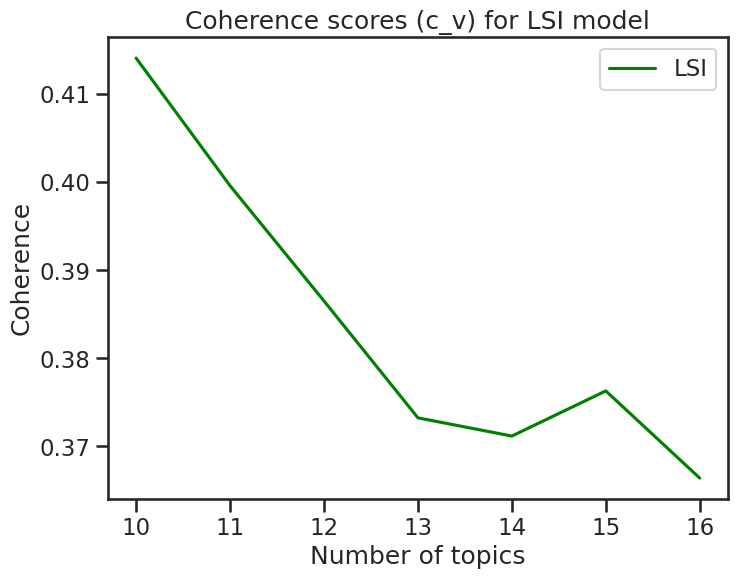

In [ ]:
import sys
sys.path.insert(0, "../")
import os
import numpy as np
from dataset import ArXivDataset
from gensim.models import LsiModel, CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")

def run_lsi():
    # Load dataset
    dataset_path = "./data/dataset.obj"
    dataset = ArXivDataset.load(dataset_path)
    print("# papers: {s}".format(s=len(dataset)))

    # Set hyperparameters
    num_topics_list = [10, 11, 12, 13, 14, 15, 16]

    lsi_model_list = []
    lsi_score_list = []
    for num_topics in num_topics_list:
        model = LsiModel(
            corpus=dataset.corpus,
            id2word=dataset.idx2word,
            num_topics=num_topics
        )
        lsi_model_list.append(model)
        coherence_model = CoherenceModel(
            model=model,
            texts=dataset.documents,
            dictionary=dataset.idx2word,
            coherence="c_v"
        )
        score = coherence_model.get_coherence()
        lsi_score_list.append(score)
        print("LSI * num_topics: {n:02d}\tscore: {s:.3f}".format(n=num_topics, s=score))

    # Plot coherence scores
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title("Coherence scores (c_v) for LSI model")
    sns.lineplot(x=num_topics_list, y=lsi_score_list, label="LSI", ax=ax, color="green")
    ax.set_xlabel("Number of topics")
    ax.set_ylabel("Coherence")
    plt.show()

if __name__ == '__main__':
    run_lsi()


# papers: 390151
NMF * num_topics: 10	score: 0.493
NMF * num_topics: 11	score: 0.495
NMF * num_topics: 12	score: 0.509
NMF * num_topics: 13	score: 0.522
NMF * num_topics: 14	score: 0.523
NMF * num_topics: 15	score: 0.530
NMF * num_topics: 16	score: 0.536


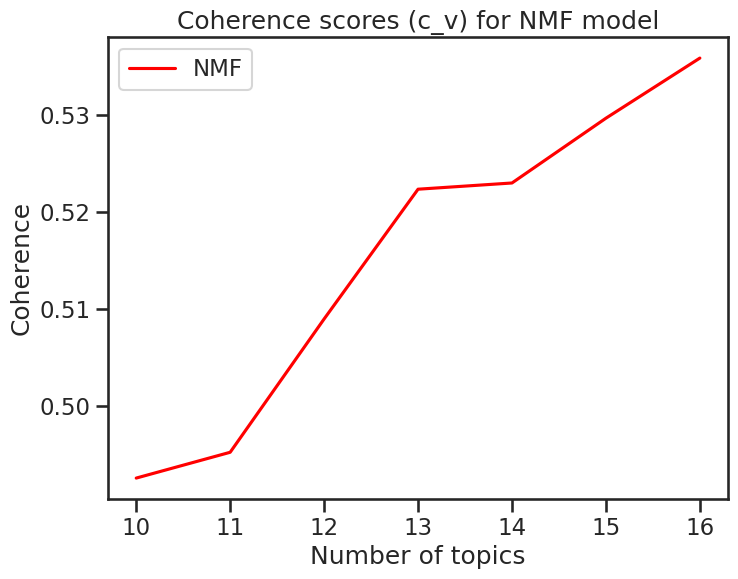

In [ ]:
import sys
sys.path.insert(0, "../")
import os
import numpy as np
from dataset import ArXivDataset
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")

def run_nmf():
    # Load dataset
    dataset_path = "./data/dataset.obj"
    dataset = ArXivDataset.load(dataset_path)
    print("# papers: {s}".format(s=len(dataset)))

    # Set hyperparameters
    num_topics_list = [10, 11, 12, 13, 14, 15, 16]
    random_state = 929

    vectorizer = CountVectorizer(max_features=5000)
    data_vectorized = vectorizer.fit_transform([' '.join(doc) for doc in dataset.documents])
    nmf_score_list = []
    nmf_model_list = []
    for num_topics in num_topics_list:
        nmf_model = NMF(n_components=num_topics, random_state=random_state)
        W = nmf_model.fit_transform(data_vectorized)
        H = nmf_model.components_
        topics = [[vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]] for topic in H]
        coherence_model = CoherenceModel(
            topics=topics,
            texts=dataset.documents,
            dictionary=dataset.idx2word,
            coherence="c_v"
        )
        score = coherence_model.get_coherence()
        nmf_model_list.append(nmf_model)
        nmf_score_list.append(score)
        print("NMF * num_topics: {n:02d}\tscore: {s:.3f}".format(n=num_topics, s=score))

    # Plot coherence scores
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title("Coherence scores (c_v) for NMF model")
    sns.lineplot(x=num_topics_list, y=nmf_score_list, label="NMF", ax=ax, color="red")
    ax.set_xlabel("Number of topics")
    ax.set_ylabel("Coherence")
    plt.show()

if __name__ == '__main__':
    run_nmf()


In [7]:

import sys
sys.path.insert(0, "../")
import os
import numpy as np
from dataset import ArXivDataset
from gensim.models import HdpModel, CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns
import logging

sns.set_context("talk")
sns.set_style("ticks")

# 忽略特定的警告
logging.getLogger('gensim.models.hdpmodel').setLevel(logging.ERROR)

def run_hdp():
    # Load dataset
    dataset_path = "./data/dataset.obj"
    dataset = ArXivDataset.load(dataset_path)
    print("# papers: {s}".format(s=len(dataset)))

    # Run HDP
    hdp_model = HdpModel(
        corpus=dataset.corpus,
        id2word=dataset.idx2word
    )
    coherence_model = CoherenceModel(
        model=hdp_model,
        texts=dataset.documents,
        dictionary=dataset.idx2word,
        coherence="c_v"
    )
    hdp_score = coherence_model.get_coherence()
    print("HDP score: {:.3f}".format(hdp_score))

run_hdp()

NotImplementedError: cannot instantiate 'WindowsPath' on your system